# Finding active TFs, attempt #2
Previous methods were working quite poorly, so I'm going to try the new method Avanti developed (would be too messy to continue editing the previous code). The key differences are (1) normalize the filters, (2) set the non-sequence bases to 0 in the filters when computing the convolution, and (3) use the summed sequence deeplift tracks rather than multiplier tracks.

Load motifs, convert to log odds space, normalize to unit magnitude

In [2]:
%load_ext autoreload
%autoreload 2

In [31]:
import pandas as pd
import numpy as np
import glob
import time
from collections import OrderedDict

motifpwms = OrderedDict()

homer_path = '../../data/motifs/homer/*.motif'
t0 = time.time()
for homer_file in glob.glob(homer_path):
    with open(homer_file) as f:
        header = f.readline().strip().split('\t')
        name = header[1]
        threshold = float(header[2])
        weights = np.array(pd.read_csv(f, sep = '\t'))
        motifpwms[name] = weights
print("Took %.3f sec to load HOMER motifs" % (time.time() - t0))

print("Number of PWMs: %d" % len(motifpwms))

#convert the motifs to log-odds space
def log_odds_space(pwm, background,pseudocount):
    new_pwm = []
    for pos_values in np.transpose(pwm,(1,0)):
        if sum(pos_values)==0:
            new_pwm.append(pos_values)
        else:
            pos_values = pos_values+pseudocount/(1+pseudocount*4)
            new_pwm.append(np.log(pos_values) - np.log(background))
    return np.array(new_pwm).transpose(1,0)

maxPwmLen = np.max([pwm.shape[0] for pwm in motifpwms.values()])
pwmArray = np.ndarray(shape = (len(motifpwms), 4, maxPwmLen), dtype = np.float32)
for (i, pwm) in enumerate(motifpwms.values()):
    if pwm.shape[0] < maxPwmLen:
        padLen = maxPwmLen - pwm.shape[0]
        padded_pwm = np.concatenate((np.zeros((padLen/2, 4)), pwm, np.zeros((padLen/2, 4))))
        if padded_pwm.shape[0] < maxPwmLen:
            padded_pwm = np.concatenate((padded_pwm, np.zeros((1, 4))))
        pwmArray[i] = log_odds_space(pwm=np.swapaxes(padded_pwm, 0, 1).astype(np.float32),
                                     background=[0.254, 0.246, 0.246, 0.254],
                                     pseudocount=0.001)
    else:
        pwmArray[i] = np.swapaxes(pwm, 0, 1).astype(np.float32)

#normalize to unit magnitude for projection
normalizedPwmArray = pwmArray/(np.linalg.norm(np.reshape(pwmArray,(pwmArray.shape[0],-1)),axis=1))[:,None,None]

Took 0.755 sec to load HOMER motifs
Number of PWMs: 344


In [3]:
import h5py

train_data_path = '../hdf5files/sharpr_znormed_jul23/train_data.hdf5'
data = h5py.File(train_data_path)

data_X = np.array(data['X/sequence'])[::2]
data_Y = np.array(data['Y/output'])

In [4]:
from collections import OrderedDict

modelName = "record_13_model_bgGhy_" 

task_to_deeplift_contribs = OrderedDict()
t0 = time.time()
# for task_idx in [2, 5, 8, 11]:
for task_idx in [2]:
    path = '../deeplift_scores/%s/contribs_reshaped_task%d.tab' % (modelName[:-1], task_idx)
    task_to_deeplift_contribs[task_idx] = pd.read_csv(path, 
                                                      sep = '\t',
                                                      header = None).values
    task_to_deeplift_contribs[task_idx] = task_to_deeplift_contribs[task_idx][:, 1:]
    print task_to_deeplift_contribs[task_idx].shape
    task_to_deeplift_contribs[task_idx] = np.reshape(task_to_deeplift_contribs[task_idx], (-1, 145, 4))
    print("Reading in deepLIFT scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()

(914348, 580)
Reading in deepLIFT scores for task 2 took 132.342 sec


In [7]:
# Use summed sequence scores instead of multipliers

task_to_deeplift_summedscores = OrderedDict()
for task_idx in task_to_deeplift_contribs:
    task_to_deeplift_summedscores[task_idx] = task_to_deeplift_contribs[task_idx][::2].astype(np.float32)
    summed_scores = np.sum(task_to_deeplift_summedscores[task_idx], axis=2)
    task_to_deeplift_summedscores[task_idx] = np.expand_dims(summed_scores, axis=2)*data_X
    
print task_to_deeplift_summedscores[2].shape

(457174, 145, 4)


In [88]:
# # Save summed contrib tracks for Avanti

# import h5py

# h5f = h5py.File('../deeplift_scores/record_13_model_bgGhy/forAvanti/deepLiftSummedContribs_allSeqs.h5', 'w')
# h5f.create_dataset('summedContribs', data=task_to_deeplift_summedscores[2], compression='gzip')

# h5f.close()

In [6]:
import sys
import os
import numpy as np
import modisco
import modisco.util
import time

print task_to_deeplift_summedscores[2].shape
print normalizedPwmArray.shape

task_idxs = [2, 5, 8, 11]
convMatrices = np.ndarray((len(task_idxs), task_to_deeplift_summedscores[2].shape[0], normalizedPwmArray.shape[0]), dtype=np.float32)

t0 = time.time()
for (i, task_idx) in enumerate([2]):
    print("On task %d" % task_idx)
    chunkLen = 50000
    for seqStart in range(0, convMatrices.shape[1], chunkLen):
        seqEnd = min(seqStart + chunkLen, convMatrices.shape[1])
        print("On sequences %d to %d" % (seqStart, seqEnd))
        convScan = np.array(modisco.util.project_onto_nonzero_filters(
                           filters=normalizedPwmArray, 
                           track=task_to_deeplift_summedscores[task_idx][seqStart : seqEnd],
                           batch_size=200,
                           progress_update=None)
                           ).astype(np.float32)
        convScan = convScan[:, :, 0:1, :]
        convMatrices[i, seqStart : seqEnd] = np.max(convScan, axis=(2, 3))
    print("Computing conv matrix for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()

/home/users/rmovva/anaconda2/envs/newtheano/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla P100-PCIE-16GB (0000:82:00.0)


(457174, 145, 4)
(344, 4, 24)
On task 2
On sequences 0 to 50000
On sequences 50000 to 100000
On sequences 100000 to 150000
On sequences 150000 to 200000
On sequences 200000 to 250000
On sequences 250000 to 300000
On sequences 300000 to 350000
On sequences 350000 to 400000
On sequences 400000 to 450000
On sequences 450000 to 457174
Computing conv matrix for task 2 took 753.923 sec


In [102]:
print data_X.shape
print normalizedPwmArray.shape

backgroundMotifPresence = np.ndarray((data_X.shape[0], normalizedPwmArray.shape[0]), dtype=np.float32)

t0 = time.time()
chunkLen = 50000
for seqStart in range(0, backgroundMotifPresence.shape[0], chunkLen):
    seqEnd = min(seqStart + chunkLen, backgroundMotifPresence.shape[0])
    print("On sequences %d to %d" % (seqStart, seqEnd))
    convScan = np.array(modisco.util.project_onto_nonzero_filters(
                       filters=normalizedPwmArray, 
                       track=data_X[seqStart : seqEnd],
                       progress_update=None)
                       ).astype(np.float32)
    convScan = convScan[:, :, 0:1, :]
    backgroundMotifPresence[seqStart : seqEnd] = np.max(convScan, axis=(2, 3))
print("Computing PWM-sequence motif conv matrix took %.3f sec" % (time.time() - t0))

(457174, 145, 4)
(344, 4, 24)
On sequences 0 to 50000
On sequences 50000 to 100000
On sequences 100000 to 150000
On sequences 150000 to 200000
On sequences 200000 to 250000
On sequences 250000 to 300000
On sequences 300000 to 350000
On sequences 350000 to 400000
On sequences 400000 to 450000
On sequences 450000 to 457174
Computing PWM-sequence motif conv matrix took 779.434 sec


In [ ]:
import pandas as pd

modelName = "record_13_model_bgGhy_"
    
t0 = time.time()
for (i, task_idx) in enumerate([2]):
    df = pd.DataFrame(convMatrices[i])
    df.to_csv("../deeplift_scores/%s/deepliftsummedscores_normalizedlogoddspwms_convmatrix_task%d.tab" % (modelName[:-1], task_idx),
              sep = '\t',
              header = False,
              index = False
             )
    print("Writing PWM deeplift scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()
    
# df = pd.DataFrame(backgroundMotifPresence)
# df.to_csv("../deeplift_scores/normalizedlogoddspwm_sequence_convmatrix_backgroundmotifs.tab",
#               sep = '\t',
#               header = False,
#               index = False
#              )
# print("Writing background motif scores took %.3f sec" % (time.time() - t0))

In [8]:
import pandas as pd

modelName = "record_13_model_bgGhy_"

task_idxs = [2]
convMatrices = np.ndarray((len(task_idxs), task_to_deeplift_summedscores[2].shape[0], pwmArray.shape[0]), dtype=np.float32)

t0 = time.time()
for (i, task_idx) in enumerate(task_idxs):
    path = "../deeplift_scores/%s/deepliftsummedscores_normalizedlogoddspwms_convmatrix_task%d.tab" % (modelName[:-1], task_idx)
    convMatrices[i] = pd.read_csv(path, 
                                  sep = '\t',
                                  header = None,
                                  index_col = False).values
    print("Reading in normed log odds PWM deeplift convolution scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()

Reading in normed log odds PWM deeplift convolution scores for task 2 took 37.535 sec


116101
3.94405


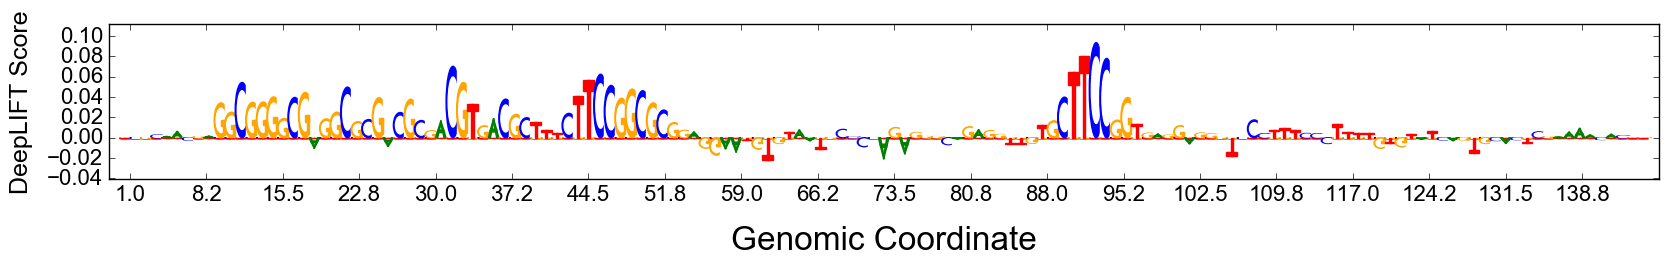

In [29]:
from deeplift.visualization import viz_sequence

labels = np.array(data_Y[:, 2])[::2]

topSeqIdxs = np.argsort(labels)[::-1][101:102]
# topSeqIdxs = np.argsort(labels)[100:110]
for idx in topSeqIdxs:
    print idx
    print labels[idx]
    viz_sequence.plot_weights(task_to_deeplift_summedscores[2][idx])

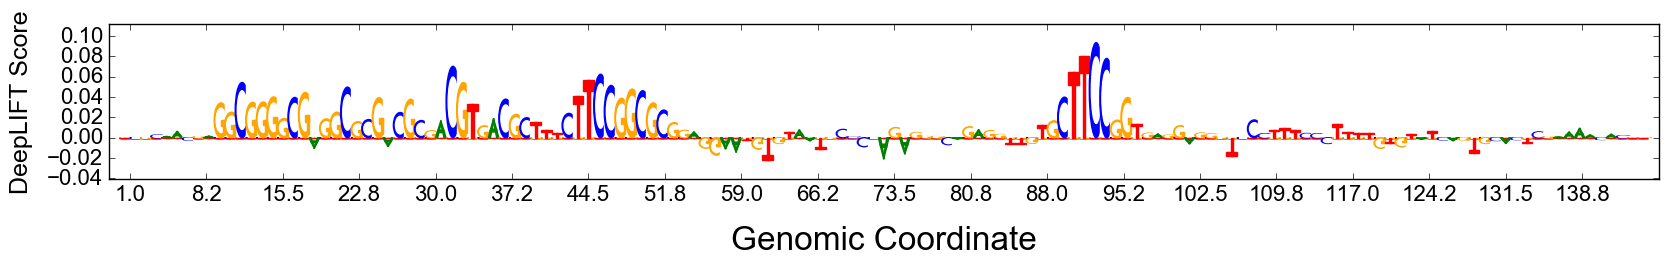

0.0423623
142
Nkx3.1(Homeobox)/LNCaP-Nkx3.1-ChIP-Seq(GSE28264)/Homer
0.170981


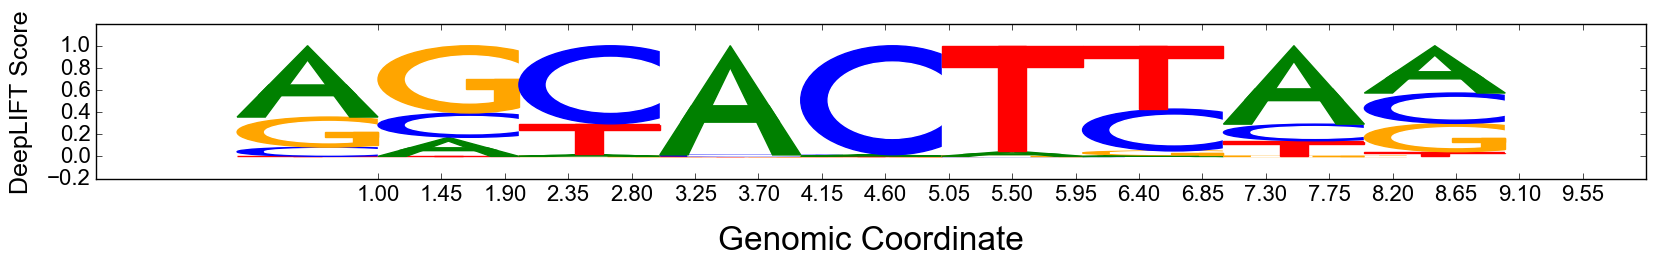

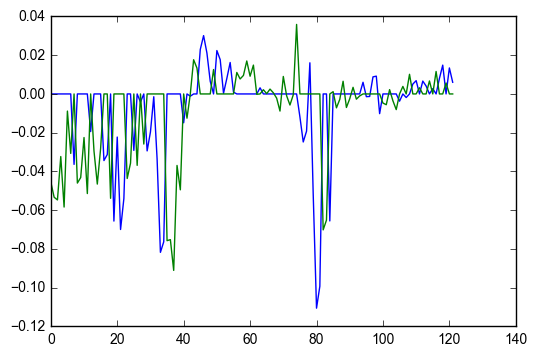

172
DMRT6(DM)/Testis-DMRT6-ChIP-Seq(GSE60440)/Homer
0.166848


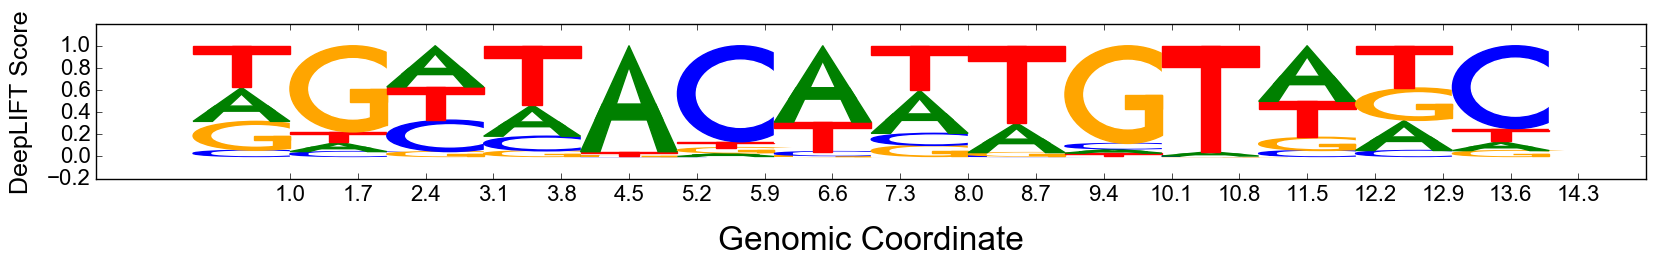

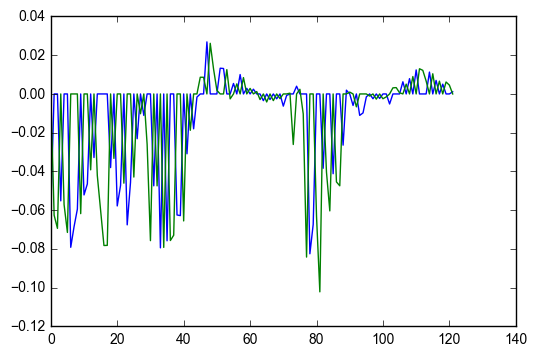

93
Arnt:Ahr(bHLH)/MCF7-Arnt-ChIP-Seq(Lo_et_al.)/Homer
0.165356


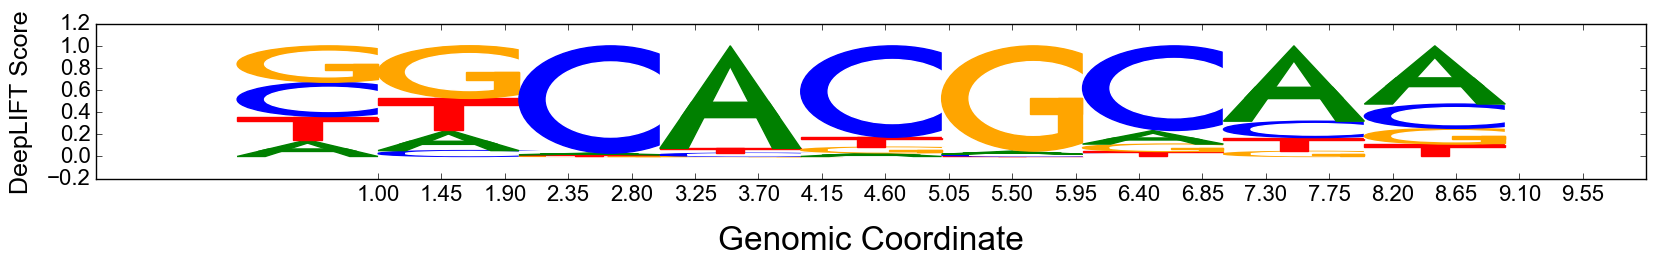

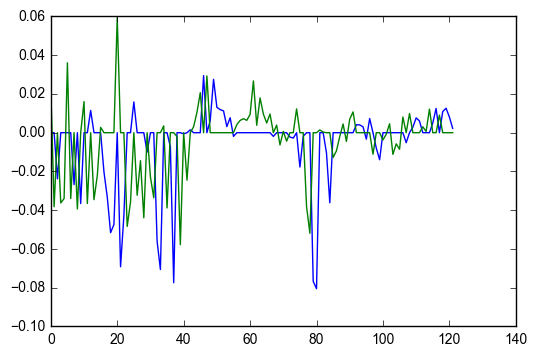

199
NFkB-p65-Rel(RHD)/ThioMac-LPS-Expression(GSE23622)/Homer
0.163819


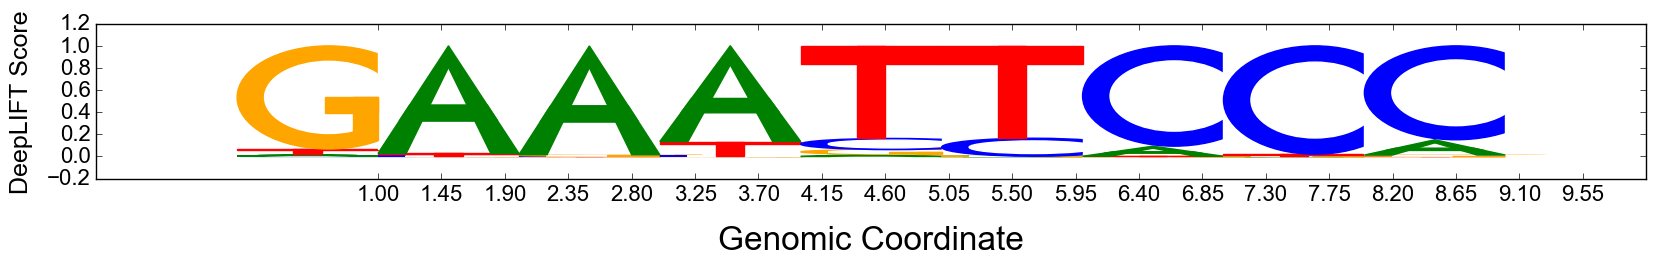

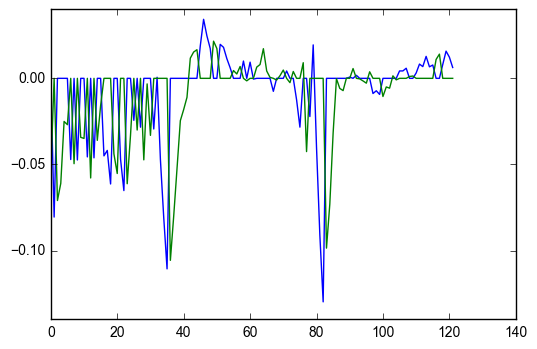

82
Gata6(Zf)/HUG1N-GATA6-ChIP-Seq(GSE51936)/Homer
0.162161


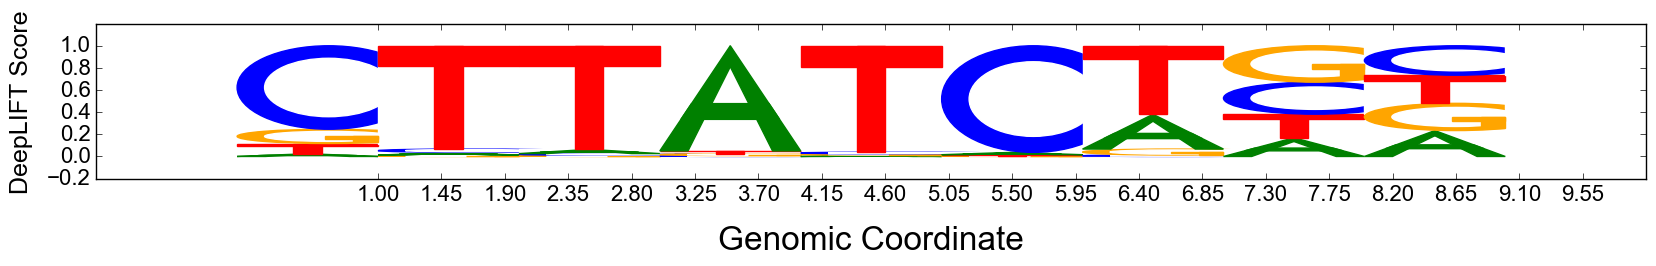

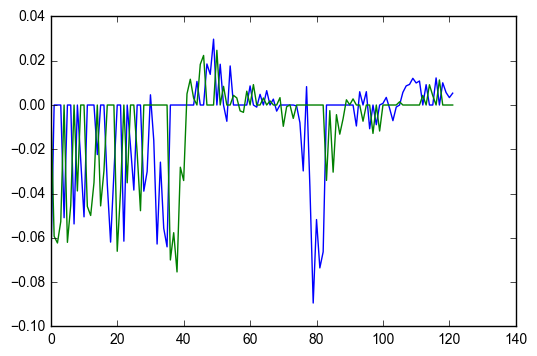

In [35]:
# import matplotlib.pyplot as plt

import modisco
import modisco.util
import matplotlib.pyplot as plt

motifnames = np.array(motifpwms.keys())

seq_idx = 116101

viz_sequence.plot_weights(task_to_deeplift_summedscores[2][seq_idx])

nTopMotifs = 5
topMotifIdxs = np.argsort(convMatrices[0][seq_idx])[::-1][:nTopMotifs]
convScanForMotifs = np.array(modisco.util.project_onto_nonzero_filters(
                       filters=normalizedPwmArray[topMotifIdxs], 
                       track=task_to_deeplift_summedscores[task_idx][seq_idx : seq_idx+1],
                       batch_size=200,
                       progress_update=None)
                       ).astype(np.float32)
print np.mean(convMatrices[0][seq_idx])
for (i, idx) in enumerate(topMotifIdxs):
    print idx
    print motifnames[idx]
    print convMatrices[0][seq_idx][idx]
    viz_sequence.plot_weights(motifpwms[motifnames[idx]])
    fwd_matches = convScanForMotifs[0, i, 1] == 0
    rev_matches = convScanForMotifs[0, i, 1] == 1
    plt.plot(convScanForMotifs[0, i, 0]*fwd_matches)
    plt.plot(convScanForMotifs[0, i, 0]*rev_matches)
    plt.show()

In [33]:
import sys

topN = 13

background_probs = [0.2545, 0.2455, 0.2455, 0.2545]
def pwm_ic(pwm, background):
    pwm = np.array(pwm)
#     return -1*np.sum(pwm*np.log2(pwm / background_probs))
    return -1*np.sum(pwm*np.log2(pwm))
pwmLens = np.array([pwm.shape[0] for pwm in motifpwms.values()])
pwmInfoContents = np.array([pwm_ic(pwm, background_probs) for pwm in motifpwms.values()])

# print pwmInfoContents

# normalizedConvMatrices = np.ndarray(shape = convMatrices.shape, dtype = np.float32)
# normalizedConvMatrices[0] = convMatrices[0] / backgroundMotifPresence

print "Max sum deepLIFT*PWM scores"
topMotifIdxs = np.argsort(np.sum(convMatrices[0], axis=0))[::-1][:topN]
print np.array(motifpwms.keys())[topMotifIdxs]
print (np.sum(convMatrices[0], axis=0))[topMotifIdxs]

# print "Max sum deepLIFT*PWM scores normalized by information content"
# topMotifIdxs = np.argsort(np.sum(convMatrices[0], axis=0) / pwmInfoContents)[::-1][:topN]
# print np.array(motifpwms.keys())[topMotifIdxs]
# print (np.sum(convMatrices[0], axis=0))[topMotifIdxs]

Max sum deepLIFT*PWM scores
['Srebp2(bHLH)/HepG2-Srebp2-ChIP-Seq(GSE31477)/Homer'
 'BMYB(HTH)/Hela-BMYB-ChIP-Seq(GSE27030)/Homer'
 'Smad3(MAD)/NPC-Smad3-ChIP-Seq(GSE36673)/Homer'
 'FoxL2(Forkhead)/Ovary-FoxL2-ChIP-Seq(GSE60858)/Homer'
 'DMRT6(DM)/Testis-DMRT6-ChIP-Seq(GSE60440)/Homer'
 'Unknown-ESC-element(?)/mES-Nanog-ChIP-Seq(GSE11724)/Homer'
 'Nkx3.1(Homeobox)/LNCaP-Nkx3.1-ChIP-Seq(GSE28264)/Homer'
 'GATA(Zf),IR3/iTreg-Gata3-ChIP-Seq(GSE20898)/Homer'
 'Gata6(Zf)/HUG1N-GATA6-ChIP-Seq(GSE51936)/Homer'
 'Arnt:Ahr(bHLH)/MCF7-Arnt-ChIP-Seq(Lo_et_al.)/Homer'
 'NF1(CTF)/LNCAP-NF1-ChIP-Seq(Unpublished)/Homer'
 'Maz(Zf)/HepG2-Maz-ChIP-Seq(GSE31477)/Homer'
 'TEAD2(TEA)/Py2T-Tead2-ChIP-Seq(GSE55709)/Homer']
[ 21207.29101562  20458.60351562  20111.015625    19373.49023438
  15914.453125    15671.19238281  15667.74609375  15648.16210938
  15537.25097656  15517.92382812  15494.23925781  15450.32128906
  15445.04199219]


In [9]:
import gzip

names = gzip.open('../splits/sharpr_znormed_jul23/train_split.txt.gz', 'rb').readlines()
names = [names[i].strip()[:-2] for i in range(len(names)) if i%2 == 0]

shortMotifNames = [mName.split('(')[0] for mName in motifpwms.keys()]

df = pd.DataFrame(convMatrices[0])
df.index = names
df.columns = shortMotifNames

In [36]:
print convMatrices[0].shape
print np.sum(convMatrices[0].ravel() > 0)
print np.sum(convMatrices[0].ravel() < 0)
print convMatrices[0].ravel()[convMatrices[0].ravel() < 0]

(457174, 344)
157267851
5
[-0.0008378  -0.0022346  -0.00074386 -0.00145437 -0.00128756]


In [10]:
# homerTfs = ['ETS', 'NFY', 'AP1', 'bZIP', 'Sp', 'Atf', 'ATF', 
#             'NRF', 'Promoter', 'Jun', 'GFX', 'GFY', 'KLF', 'Klf',
#             'HLH', 'ZBTB33', 'CRE', 'YY1', 'ZNF143', 'RUNX',
#             'GATA', 'JUN', 'Stat', 'MafB', 'IRF', 'SpiB', 'CEBP', 'Maz',
#            ]
# homerTfs = ['ETS', 'NFY', 'AP1', 'Sp', 'Atf', 'NRF', 
#             'YY1', 'KLF', 'GATA', 'RUNX',
#             'CTCF', 'REST', 
#            ]
# homerTfs = ['ETS', 'AP1' 'Sp1', 'KLF', 'YY1', 
#             'NFY', 'NRF', 'REST',
#             'ZBTB33', 'Myc', 'TATA', 'SNAI',
#             'bZIP']
homerTfs = ['ETS1', 'ELF5', 'ELF3', 'SpiB', 'ELK', 'ETV', 'AP-1', 'Sp1', 'Sp5', 'KLF14', 'KLF3', 'YY1', 
            'NFY', 'NRF1', 'PU.1',
            'ZBTB33', 'c-Myc', 'TATA', 'SNAI',
            'Atf3', 'BATF', 'Fos',
            'GATA', 'RUNX1', 'Runt', 'HNF4', 'Cre', 'MafB', 'MafK', 'MafF']
homerTfs = homerTfs + [tf.lower() for tf in homerTfs] + [tf.upper() for tf in homerTfs]
#             'NRF', 'Promoter', 'Jun', 'GFY', 'KLF', 'Klf',
#             'ZBTB33', 'CRE', 'YY1', 'ZNF143', 'RUNX',
#             'GATA', 'JUN', 'Stat', 'MafB', 'IRF', 'SpiB',
#            ]
idxs = []
for (i, tf) in enumerate(shortMotifNames):
    for curatedTf in homerTfs:
        if (tf.find(curatedTf) != -1 and tf.find(':') == -1 and tf.find('_') == -1 and 
            tf.find('-I') == -1 and tf.find('c-Jun-CRE') == -1 and tf.find('GATA3') == -1):
            idxs.append(i)
            continue
# idxs.append(13)
corrMatMotifIdxs = np.array(list(set(idxs)))

In [11]:
# Class 01 Tss Active Promoter
# Class 02 TssF Active Promoter
# Class 03 PromF Promoter Flanking
# Class 04 PromP Promoter Poised
# Class 05 Enh Strong Enhncer
# Class 06 EnhF Strong Enhancer F
# Class 07 EnhW Weak Enhancer
# Class 08 EnhWF Enhancer Poised or Weak
# Class 09 DnaseU DNase UW
# Class 10 DnaseD DNase Duke
# Class 11 FaireW Modest FAIRE
# Class 12 CtcfO Distal CTCF Chrom
# Class 13 Ctcf Distal CTCF NoChrom
# Class 14 Gen5 Transcription transition
# Class 15 Elon Transcription elongation
# Class 16 ElonW Transcription elongation - weak
# Class 17 Gen3 Transcription elongation - 3' end
# Class 18 Pol2 Transcription Pol2
# Class 19 H4K20 Transcription intronic
# Class 20 ReprD Polycomb Repressed - Conserved
# Class 21 Repr Polycomb Repressed
# Class 22 ReprW Polycomb Repressed - Weak
# Class 23 Low Low Signal
# Class 24 Quies Hetrochromatin
# Class 25 Art Repeats CNV's, artifacts
# Class 26 Null No Class provided
states_to_compare = [[1,2,3,4], [5], [20, 21], [24]]
state_names = ['Promoter', 'Enhancer', 'Repressed', 'Quiescent']
# states_to_compare = [[1,2], [5]]
# state_names = ['Promoter', 'Enhancer']

state_idxs = []
for (i, state) in enumerate(states_to_compare):
    state_idxs.append([])
    for (idx, fragment) in enumerate(np.array(df.index)):
        if fragment.split('_')[0] != 'K562':
            continue
        if int(fragment.split('_')[1]) in state:
            state_idxs[i].append(idx)
            
for (i, state) in enumerate(state_names):
    print("%s: %d" % (state_names[i], len(state_idxs[i])))

Promoter: 14904
Enhancer: 34896
Repressed: 2046
Quiescent: 1393


In [12]:
from scipy.stats import zscore

valsByState = []
for state in state_idxs:
    valsByState.append(np.mean(df.iloc[state], axis = 0))
    
valsByState = np.array(valsByState)

df_states = pd.DataFrame(data = np.transpose(valsByState),
                         index = df.columns,
                         columns = state_names)
enhPromRatioList = zscore([np.mean(df_states.get_value(motif, 'Promoter')) / np.mean(df_states.get_value(motif, 'Enhancer'))
                           for motif in df_states.index])
df_states = df_states.iloc[corrMatMotifIdxs]

import seaborn as sns

# sns.clustermap(df_states,
#                cmap = 'RdBu_r',
# #                metric = 'correlation',
# #                row_linkage = linkage,
# #                col_linkage = linkage,
#                z_score = 1,
#                col_cluster = False,
#                row_cluster = True,
# #                linewidths=.75, 
#                figsize=(12, 12)
#               )

# plt.show()

In [27]:
# motifs = ['Sp1(Zf)', 'NRF1(NRF)']

# promEnhRatios = {motif: np.mean(df_states.get_value(motif, 'Enhancer')) / np.mean(df_states.get_value(motif, 'Promoter'))
#                  for motif in df_states.index}
promEnhRatios = {shortMotifNames[idx]: enhPromRatioList[idx] for idx in corrMatMotifIdxs}
print len(promEnhRatios)
ratio_df = pd.DataFrame.from_dict(promEnhRatios, orient = 'index')
ratio_df.columns = ['ratio']
ratio_df['tf'] = ratio_df.index
ratio_df.index = np.arange(len(ratio_df.index))
ratio_df.sort_values(by=['ratio'], ascending=False, inplace = True)
print ratio_df

ratio_df.to_csv('../plots/deeplift/regGrammars/promEnhZScores_sep23removeP53.csv')

27
       ratio        tf
9   2.568099       Sp1
13  2.049267      MafF
15  1.949101    ZBTB33
20  1.224804      MafK
14  0.874783  TATA-Box
12  0.763434      KLF3
11  0.524678      ETS1
7   0.480801      ELF5
18  0.431279     c-Myc
0   0.424217      BATF
23 -0.097149      ETV1
2  -0.115599      AP-1
19 -0.187591     HNF4a
6  -0.201417      ELF3
10 -0.249905       Sp5
17 -0.260481      Atf3
5  -0.263795     Fosl2
21 -0.366107      MafB
3  -0.382588       CRE
16 -0.505929      GATA
4  -0.628378      SpiB
1  -0.919412       YY1
8  -0.932978     KLF14
25 -1.167686      PU.1
22 -1.219905       NFY
26 -1.545254      NRF1
24 -2.030298     RUNX1


In [14]:
print len(corrMatMotifIdxs)

usedNames = []
for j in range(len(corrMatMotifIdxs) - 1, -1, -1):
    idx = corrMatMotifIdxs[j]
#     print idx
    if shortMotifNames[idx] in usedNames:
        corrMatMotifIdxs = np.concatenate((corrMatMotifIdxs[:j], corrMatMotifIdxs[j+1:]))
    usedNames.append(shortMotifNames[idx])

# print usedNames
        
print len(corrMatMotifIdxs)
# print np.array(shortMotifNames)[corrMatMotifIdxs]
        
df_selected = df.iloc[:,corrMatMotifIdxs]
print df_selected.values.shape
# corr = df_selected.corr(method = 'spearman')

27
27
(457174, 27)


In [15]:
import pandas as pd

# corr.to_csv("../plots/tfanalysis/selected_tfcorrmatrix_17sep_noP53.tab",
#               sep = '\t',
# #               header = False,
# #               index = False
#              )

corr = pd.read_csv("../plots/tfanalysis/selected_tfcorrmatrix_17sep_noP53.tab",
                   sep = '\t',
                   index_col = 0)

In [16]:
corr

,KLF3,RUNX1,ELF5,Sp1,MafF,MafK,ETV1,TATA-Box,Fosl2,NFY,...,CRE,BATF,ETS1,GATA,NRF1,c-Myc,ZBTB33,YY1,MafB,PU.1
KLF3,1.000000,0.729415,0.650186,0.939906,0.341688,0.422693,0.605716,0.414825,0.446402,0.691842,...,0.760274,0.415978,0.619756,0.419118,0.756728,0.729297,0.722463,0.726252,0.446772,0.700283
RUNX1,0.729415,1.000000,0.716956,0.695786,0.601152,0.598833,0.700379,0.641382,0.589614,0.812614,...,0.730690,0.600507,0.747936,0.636701,0.671125,0.796495,0.733907,0.822155,0.630333,0.776608
ELF5,0.650186,0.716956,1.000000,0.639797,0.413541,0.445856,0.903043,0.461755,0.462980,0.681679,...,0.670994,0.439744,0.907890,0.439666,0.625202,0.703792,0.668092,0.686573,0.462585,0.888888
Sp1,0.939906,0.695786,0.639797,1.000000,0.298493,0.389501,0.592827,0.374012,0.416575,0.659941,...,0.736457,0.380511,0.599615,0.367788,0.753185,0.703707,0.701620,0.697307,0.405607,0.685126
MafF,0.341688,0.601152,0.413541,0.298493,1.000000,0.763348,0.470377,0.757290,0.655099,0.575646,...,0.337322,0.738596,0.553605,0.809230,0.252207,0.501870,0.397876,0.623121,0.820961,0.504832
MafK,0.422693,0.598833,0.445856,0.389501,0.763348,1.000000,0.476566,0.653676,0.837626,0.586860,...,0.433739,0.888374,0.552205,0.673997,0.351364,0.527226,0.446768,0.621606,0.865608,0.533198
ETV1,0.605716,0.700379,0.903043,0.592827,0.470377,0.476566,1.000000,0.518192,0.472856,0.681961,...,0.619285,0.466352,0.927183,0.486407,0.565262,0.694318,0.635128,0.684573,0.498182,0.834475
TATA-Box,0.414825,0.641382,0.461755,0.374012,0.757290,0.653676,0.518192,1.000000,0.555543,0.642162,...,0.394082,0.647523,0.586477,0.769875,0.320651,0.578846,0.496201,0.663936,0.697955,0.540833
Fosl2,0.446402,0.589614,0.462980,0.416575,0.655099,0.837626,0.472856,0.555543,1.000000,0.585958,...,0.469767,0.917045,0.534038,0.572767,0.383519,0.513944,0.448540,0.579327,0.721188,0.537542
NFY,0.691842,0.812614,0.681679,0.659941,0.575646,0.586860,0.681961,0.642162,0.585958,1.000000,...,0.713688,0.577786,0.716854,0.593798,0.628105,0.811723,0.732248,0.783016,0.609374,0.729586


In [17]:
corr.index = np.array(shortMotifNames)[corrMatMotifIdxs]
corr.columns = corr.index

In [18]:
print corr.index
tfClasses = pd.Series(
             [1, -1, 2, 1, 3, 3, 2,
             -1, 3, -1, 1, 3, 3, 2,
             -1, 2, 1, 3, 3, 2, -1, -1,
             -1, -1, -1, 3, 2])
# tfClasses = pd.Series(
#              [1, -1, 3, 1, 3, 3, 3,
#              -1, 3, -1, 1, 3, 3, 3,
#              -1, 3, 1, 3, 3, 3, -1, -1,
#              -1, -1, -1, -1, 3, 3])
# lut = dict(zip(tfClasses.unique(), "rkbg"))
lut = dict(zip(tfClasses.unique(), ['#7f3f98', '#AAAAAA', '#00aeef', '#f26522']))
row_colors = tfClasses.map(lut)

Index([u'Fosl2', u'MafK', u'RUNX1', u'BATF', u'TATA-Box', u'NRF1', u'KLF3',
       u'ETS1', u'c-Myc', u'MafB', u'Sp5', u'ZBTB33', u'GATA', u'ELF3', u'Sp1',
       u'MafF', u'PU.1', u'SpiB', u'AP-1', u'NFY', u'ETV1', u'HNF4a', u'KLF14',
       u'YY1', u'Atf3', u'ELF5', u'CRE'],
      dtype='object')


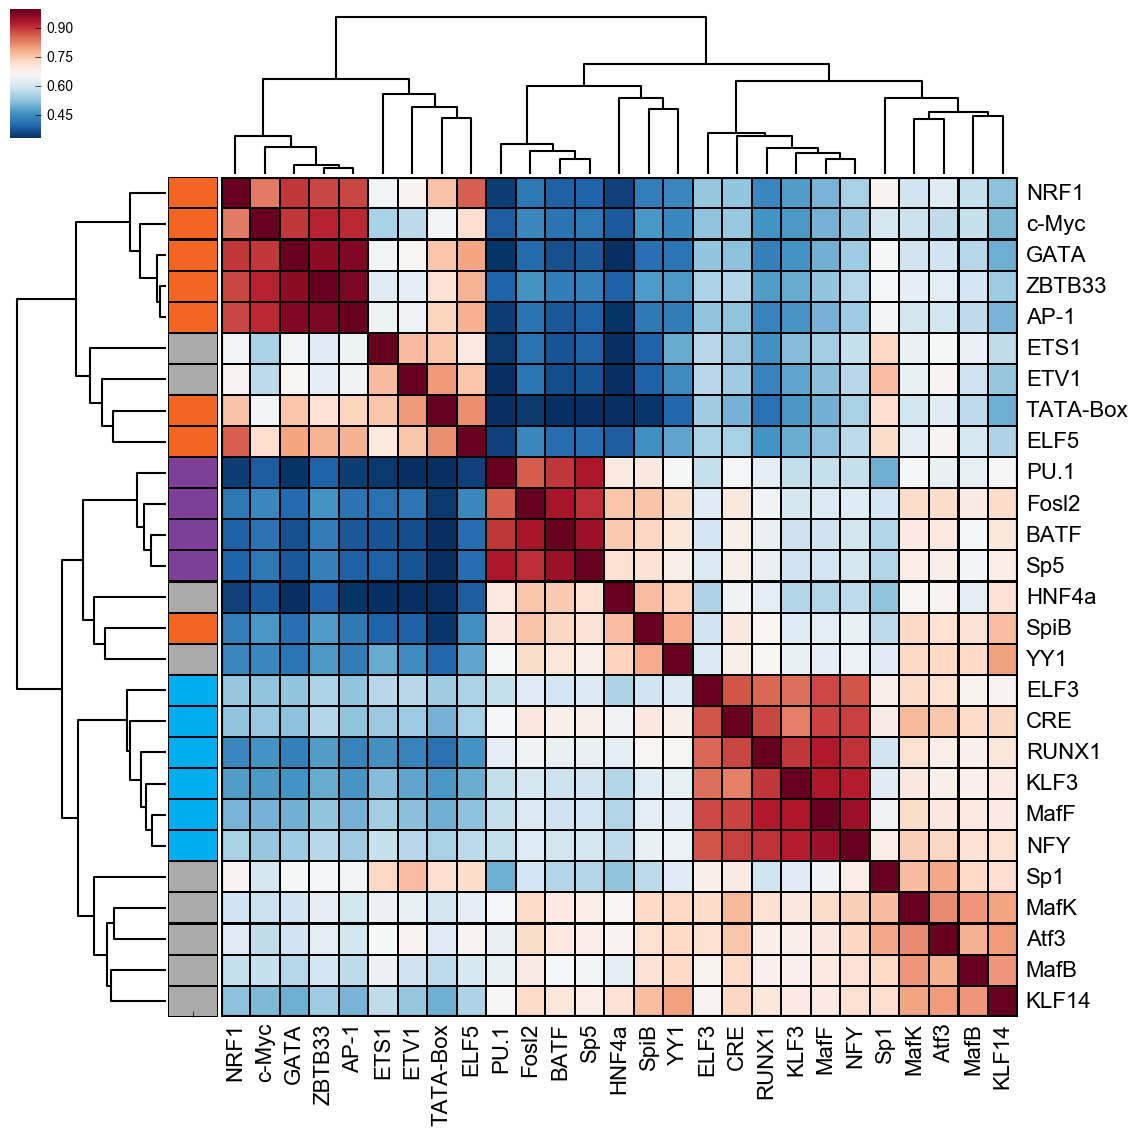

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.patches import Rectangle

dist_matrix = 1 - corr
linkage = hc.linkage(sp.distance.squareform(dist_matrix), method='average')

cg = sns.clustermap(corr.reset_index(drop=True),
               cmap = 'RdBu_r',
               row_linkage = linkage,
               col_linkage = linkage,
#                z_score = 0,
               linewidths=.8, 
               linecolor='black',
               figsize=(13, 13),
               row_colors = row_colors,
               robust = True,
#                cbar = False,
#                col_colors=row_colors,
              )

ax = cg.ax_heatmap
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 16)
ax.set_yticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 16)

ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.tick_params(axis='y', which='major', pad=6)

ax.add_patch(Rectangle((0, 0), 27, 27, fill=False, edgecolor='black', lw=3))

plt.savefig('../plots/deeplift/regGrammars/tfClustermap_sep17_average_noP53_rev2.png', dpi=600)

plt.show()

# Analysis of active TFs by convolving PWMs with deepLIFT scores

1. Load TF PWMs (HOMER should be a good enough set)
2. Load train sequences
3. Load deepLIFT scores
4. Compute PWM-deepLIFT and PWM-sequence convolution matrices using Avanti's GPU accelerated function:
https://github.com/kundajelab/modisco_private/blob/master/test/util/test_correlation.py
5. Divide the two matrices to "normalize" the PWM-deepLIFT convolution matrix. That is, the matrix entries now represent how much the motif was used by the model in making a prediction.
6. Visualize average motif usage by chromatin state.
7. Create a motif-motif correlation matrix to see which motifs were predictive together. Cluster this matrix to reproduce known TF interactions.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import glob
import time
from collections import OrderedDict

motifpwms = OrderedDict()

homer_path = '../../data/motifs/homer/*.motif'
t0 = time.time()
for homer_file in glob.glob(homer_path):
    with open(homer_file) as f:
        header = f.readline().strip().split('\t')
        name = header[1]
        threshold = float(header[2])
        weights = np.array(pd.read_csv(f, sep = '\t'))
        motifpwms[name] = weights
print("Took %.3f sec to load HOMER motifs" % (time.time() - t0))

print("Number of PWMs: %d" % len(motifpwms))

Took 1.516 sec to load HOMER motifs
Number of PWMs: 344


In [4]:
import h5py

train_data_path = '../hdf5files/sharpr_znormed_jul23/train_data.hdf5'
data = h5py.File(train_data_path)

data_X = np.array(data['X/sequence'])
data_Y = np.array(data['Y/output'])

In [5]:
labels = np.array(data_Y[:, 2])[::2]

In [6]:
from collections import OrderedDict

modelName = "record_13_model_bgGhy_" 

task_to_deeplift_contribs = OrderedDict()
t0 = time.time()
# for task_idx in [2, 5, 8, 11]:
for task_idx in [2]:
    path = '../deeplift_scores/%s/contribs_reshaped_task%d.tab' % (modelName[:-1], task_idx)
    task_to_deeplift_contribs[task_idx] = pd.read_csv(path, 
                                                      sep = '\t',
                                                      header = None).values
    task_to_deeplift_contribs[task_idx] = task_to_deeplift_contribs[task_idx][:, 1:]
    print task_to_deeplift_contribs[task_idx].shape
    task_to_deeplift_contribs[task_idx] = np.reshape(task_to_deeplift_contribs[task_idx], (-1, 145, 4))
    print("Reading in deepLIFT scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()
    
# Use summed sequence scores instead of multipliers

task_to_deeplift_summedscores = OrderedDict()
for task_idx in task_to_deeplift_contribs:
    summed_scores = np.sum(task_to_deeplift_contribs[task_idx], axis=2)
    task_to_deeplift_summedscores[task_idx] = np.expand_dims(summed_scores, axis=2)*data_X

(914348, 580)
Reading in deepLIFT scores for task 2 took 728.955 sec


In [60]:
# Save deepLIFT contribs and filter PWMs as .npy for Avanti

# np.save('../deeplift_scores/record_13_model_bgGhy/forAvanti/deepLiftMultipliers_AP1_bgGhy.npy',
#         task_to_deeplift_contribs[2][124738])

np.save('../deeplift_scores/record_13_model_bgGhy/forAvanti/sequence_AP1_124738.npy',
        data_X[124738*2])

# np.save('../deeplift_scores/record_13_model_bgGhy/forAvanti/homer_pwms_344.npy',
#         pwmArray)

# np.savetxt('../deeplift_scores/record_13_model_bgGhy/forAvanti/pwm_names.txt',
#            motifnames,
#            fmt = '%s',
#            comments = '')

(145, 4)


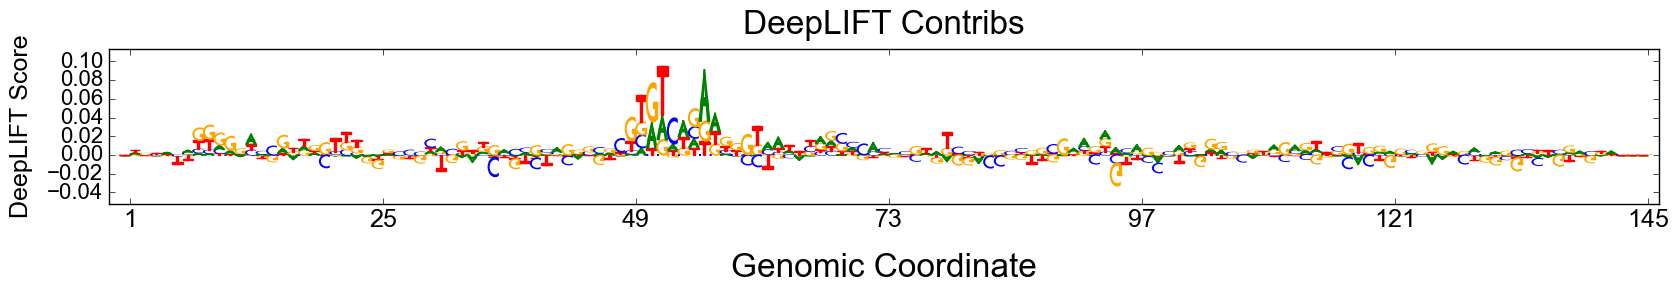

In [62]:
viz_sequence.plot_weights(
#     np.load('../deeplift_scores/record_13_model_bgGhy/forAvanti/sequence_AP1_124738.npy'),
                              task_to_deeplift_contribs[2][124738],
                              tickcount = 6,
                              figsize = (20, 2),
                              xlabel = 'Genomic Coordinate',
    #                           start_coord = start_coord,
                              xtickfontsize = 18,
                              title = 'DeepLIFT Contribs'
                             )

[124738]
4.1682


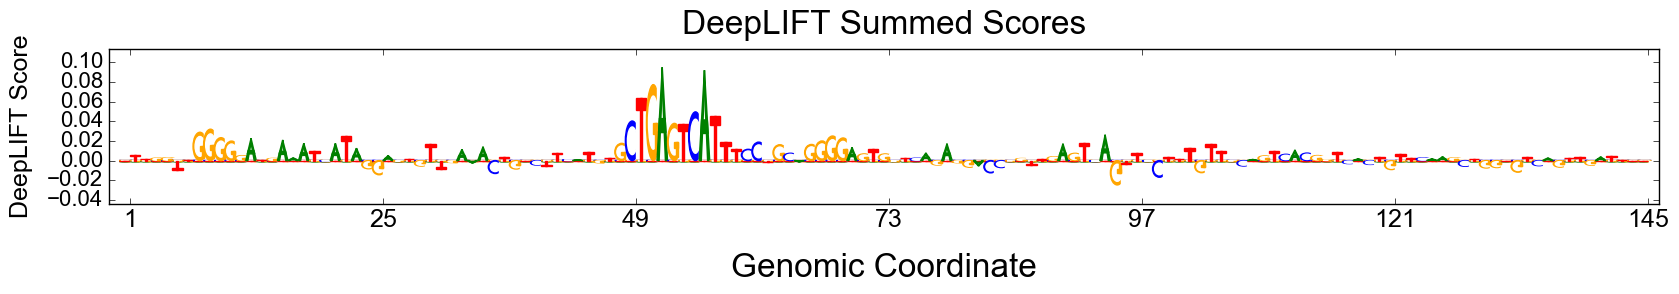

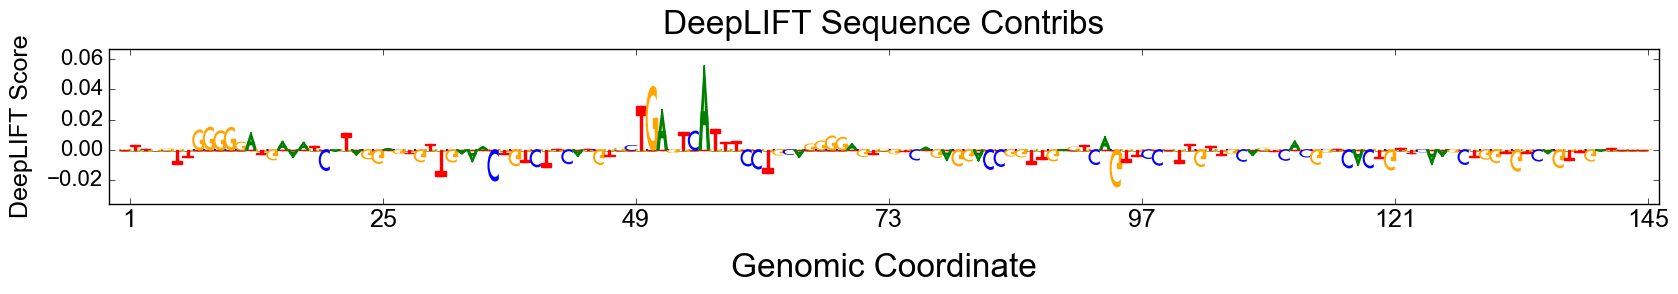

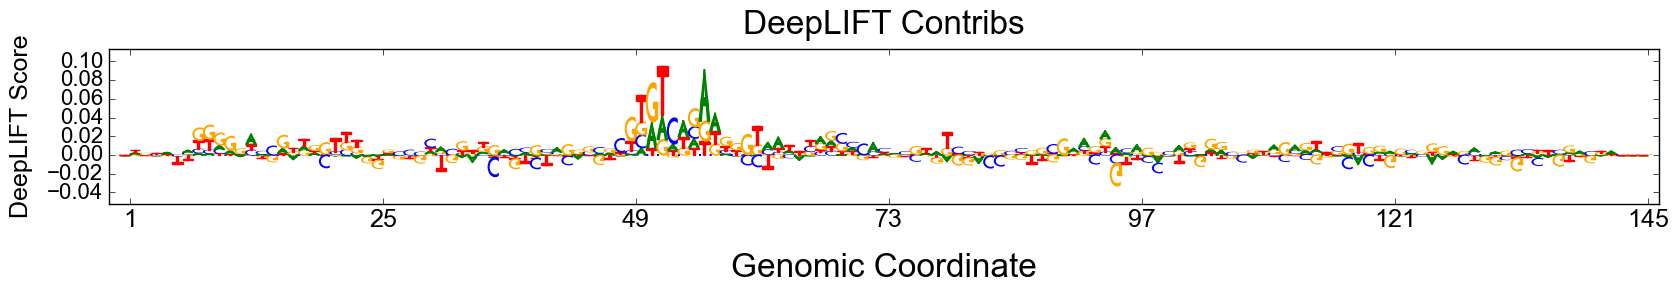

In [32]:
from deeplift.visualization import viz_sequence

idxs = np.argsort(labels)[::-1][20:21]
print idxs

for idx in idxs:
    print labels[idx]
    viz_sequence.plot_weights(task_to_deeplift_summedscores[2][2*idx],
                              tickcount = 6,
                              figsize = (20, 2),
                              xlabel = 'Genomic Coordinate',
    #                           start_coord = start_coord,
                              xtickfontsize = 18,
                              title = 'DeepLIFT Summed Scores'
                             )
    viz_sequence.plot_weights(task_to_deeplift_contribs[2][idx]*data_X[2*idx],
                              tickcount = 6,
                              figsize = (20, 2),
                              xlabel = 'Genomic Coordinate',
    #                           start_coord = start_coord,
                              xtickfontsize = 18,
                              title = 'DeepLIFT Sequence Contribs'
                             )
    viz_sequence.plot_weights(task_to_deeplift_contribs[2][idx],
                              tickcount = 6,
                              figsize = (20, 2),
                              xlabel = 'Genomic Coordinate',
#                               start_coord = 1,
                              xtickfontsize = 18,
                              title = 'DeepLIFT Contribs'
                             )

In [49]:
print task_to_deeplift_contribs[2].shape

(457174, 145, 4)


In [102]:
# Convert shape to 2D image-like for convolution function
# Update 31 Aug - removing the image-like conversion b/c the cosine distance function that
# Avanti implemented accepts samples x length x channels (ACGT)

for task_idx in task_to_deeplift_contribs:
    # notice that the first line uses summedscores, not contribs, just didn't want to change names everywhere
    task_to_deeplift_contribs[task_idx] = task_to_deeplift_summedscores[task_idx][::2].astype(np.float32)
#     task_to_deeplift_contribs[task_idx] = np.swapaxes(task_to_deeplift_contribs[task_idx], 1, 2)
#     task_to_deeplift_contribs[task_idx] = np.expand_dims(task_to_deeplift_contribs[task_idx], axis = 1)
    
print task_to_deeplift_contribs[2].shape

(457174, 145, 4)


In [95]:
from collections import OrderedDict

letterCounts = OrderedDict()
letterCounts['A'] = 0
letterCounts['C'] = 0
letterCounts['G'] = 0
letterCounts['T'] = 0

for idx in np.random.choice(np.arange(len(data_X)), 10000, replace = False):
# for idx in np.arange(10000):
    for base in data_X[idx]:
        letterCounts[letterCounts.keys()[np.argmax(base)]] += 1

# for key in letterCounts:
#     print key
#     print 1.0*letterCounts[key] / sum(letterCounts.values())
        
background = 1.0*np.array(
             [(letterCounts['A'] + letterCounts['T']) / 2,
              (letterCounts['C'] + letterCounts['G']) / 2,
              (letterCounts['C'] + letterCounts['G']) / 2,
              (letterCounts['A'] + letterCounts['T']) / 2]) / np.sum(letterCounts.values())

print background


def log_odds_space(pwm,background,pseudocount=0.001):
    new_pwm = []
    for pos_values in np.transpose(pwm,(1,0)):
        if sum(pos_values)==0:
            new_pwm.append(pos_values)
        else:
            pos_values = pos_values+pseudocount/(1+pseudocount*4)
            new_pwm.append(np.log(pos_values) - np.log(background))
    return np.array(new_pwm).transpose(1,0)

maxPwmLen = np.max([pwm.shape[0] for pwm in motifpwms.values()])
pwmArray = np.ndarray(shape = (len(motifpwms), 4, maxPwmLen), dtype = np.float32)
for (i, pwm) in enumerate(motifpwms.values()):
    if pwm.shape[0] < maxPwmLen:
        padLen = maxPwmLen - pwm.shape[0]
        padded_pwm = np.concatenate((np.zeros((padLen/2, 4)), pwm, np.zeros((padLen/2, 4))))
        if padded_pwm.shape[0] < maxPwmLen:
            padded_pwm = np.concatenate((padded_pwm, np.zeros((1, 4))))
        pwmArray[i] = log_odds_space(pwm=np.swapaxes(padded_pwm, 0, 1).astype(np.float32),
                                     background=background,
                                     pseudocount=0.01)
    else:
        pwmArray[i] = np.swapaxes(pwm, 0, 1).astype(np.float32)

[ 0.25449448  0.24550552  0.24550552  0.25449448]


In [96]:
print np.mean(task_to_deeplift_contribs[2])
print np.mean(pwmArray)

0.000193494
-0.464442


In [98]:
print pwmArray.shape
print task_to_deeplift_contribs[task_idx].shape
print data_X.shape

(344, 4, 24)
(457174, 145, 4)
(914348, 145, 4)


In [103]:
import sys
import os
import numpy as np
import modisco
import modisco.util
import time

print task_to_deeplift_contribs[2].shape
print pwmArray.shape

task_idxs = [2, 5, 8, 11]
convMatrices = np.ndarray((len(task_idxs), task_to_deeplift_contribs[2].shape[0], pwmArray.shape[0]), dtype=np.float32)

t0 = time.time()
for (i, task_idx) in enumerate([2]):
    print("On task %d" % task_idx)
    chunkLen = 50000
    for seqStart in range(0, convMatrices.shape[1], chunkLen):
#     for seqStart in range(400000, convMatrices.shape[1], chunkLen):
        seqEnd = min(seqStart + chunkLen, convMatrices.shape[1])
        print("On sequences %d to %d" % (seqStart, seqEnd))
#         convScan = np.array(modisco.util.scan_regions_with_filters(
#                            filters=pwmArray, 
#                            regions_to_scan=task_to_deeplift_contribs[task_idx][seqStart : seqEnd],
#                            progress_update=None)
#                            ).astype(np.float32)
        convScan = np.array(modisco.util.product_of_cosine_distances(
                           filters=pwmArray, 
                           track1=task_to_deeplift_contribs[task_idx][seqStart : seqEnd],
                           track2=data_X[seqStart : seqEnd],
                           batch_size=200,
                           progress_update=None)
                           ).astype(np.float32)
#         print convScan.shape
        convScan = convScan[:, :, 0:1, :]
#         print convScan.shape
#         print np.mean(convScan)
#         print convScan.shape
#         print np.max(convScan, axis=(2, 3)).shape
#         print np.mean()
        convMatrices[i, seqStart : seqEnd] = np.max(convScan, axis=(2, 3))
#         sys.exit(0)
    print("Computing conv matrix for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()
#     print("Computing max convolutions for task %d took %.3f" % (task_idx, time.time() - t0))
#     t0 = time.time()

(457174, 145, 4)
(344, 4, 24)
On task 2
On sequences 0 to 50000
On sequences 50000 to 100000
On sequences 100000 to 150000
On sequences 150000 to 200000
On sequences 200000 to 250000
On sequences 250000 to 300000
On sequences 300000 to 350000
On sequences 350000 to 400000
On sequences 400000 to 450000
On sequences 450000 to 457174
Computing conv matrix for task 2 took 759.613 sec


In [29]:
# Get background motif occurrence

data_X_reformat = data_X[::2].astype(np.float32)
data_X_reformat = np.swapaxes(data_X_reformat, 1, 2)
data_X_reformat = np.expand_dims(data_X_reformat, axis = 1)
    
print data_X_reformat.shape
print pwmArray.shape

backgroundMotifPresence = np.ndarray((data_X_reformat.shape[0], pwmArray.shape[0]), dtype=np.float32)

t0 = time.time()
chunkLen = 50000
for seqStart in range(0, backgroundMotifPresence.shape[0], chunkLen):
    seqEnd = min(seqStart + chunkLen, backgroundMotifPresence.shape[0])
    print("On sequences %d to %d" % (seqStart, seqEnd))
    convScan = np.array(modisco.util.scan_regions_with_filters(
                       filters=pwmArray, 
                       regions_to_scan=data_X_reformat[seqStart : seqEnd],
                       progress_update=None)
                       ).astype(np.float32)
    convScan = convScan[:, :, 0:1, :]
    backgroundMotifPresence[seqStart : seqEnd] = np.max(convScan, axis=(2, 3))
print("Computing PWM-sequence motif conv matrix took %.3f sec" % (time.time() - t0))

(457174, 1, 4, 145)
(344, 4, 24)
On sequences 0 to 50000
On sequences 50000 to 100000
On sequences 100000 to 150000
On sequences 150000 to 200000
On sequences 200000 to 250000
On sequences 250000 to 300000
On sequences 300000 to 350000
On sequences 350000 to 400000
On sequences 400000 to 450000
On sequences 450000 to 457174
Computing PWM-sequence motif conv matrix took 759.929 sec


In [104]:
import pandas as pd

modelName = "record_13_model_bgGhy_"
    
t0 = time.time()
for (i, task_idx) in enumerate([2]):
    df = pd.DataFrame(convMatrices[i])
    df.to_csv("../deeplift_scores/%s/pwm_deepliftsummedscores_logoddspwms_convmatrix_task%d.tab" % (modelName[:-1], task_idx),
              sep = '\t',
              header = False,
              index = False
             )
    print("Writing PWM deeplift summed scores cosine distance product scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()
    
# df = pd.DataFrame(backgroundMotifPresence)
# df.to_csv("../deeplift_scores/pwm_sequence_convmatrix_backgroundmotifs.tab",
#               sep = '\t',
#               header = False,
#               index = False
#              )
# print("Writing background motif scores took %.3f sec" % (time.time() - t0))

Writing PWM deeplift summed scores cosine distance product scores for task 2 took 69.112 sec


In [45]:
import pandas as pd

modelName = "record_13_model_bgGhy_"

# task_idxs = [2,5,8,11]
# convMatrices = np.ndarray((len(task_idxs), task_to_deeplift_contribs[2].shape[0], pwmArray.shape[0]), dtype=np.float32)

# t0 = time.time()
# for (i, task_idx) in enumerate([2]):
#     path = "../deeplift_scores/%s/pwm_summeddeeplift_convmatrix_task%d.tab" % (modelName[:-1], task_idx)
#     convMatrices[i] = pd.read_csv(path, 
#                                   sep = '\t',
#                                   header = None,
#                                   index_col = False).values
#     print("Reading in PWM-summed deeplift convolution scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
#     t0 = time.time()
    
path = "../deeplift_scores/pwm_sequence_convmatrix_backgroundmotifs.tab"
backgroundMotifPresence = pd.read_csv(path, 
                                      sep = '\t',
                                      header = None,
                                      index_col = False).values.astype(np.float32)
print("Reading in background motif scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
t0 = time.time()

Reading in background motif scores for task 2 took 29.459 sec


In [40]:
motif = "AP1"
for (i, key) in enumerate(motifpwms.keys()):
    if key.find(motif) != -1:
        motif_idx = i
        break

print motif_idx
print motifpwms.keys()[motif_idx]

print convMatrices[0][114772][motif_idx]

67
CEBP:AP1(bZIP)/ThioMac-CEBPb-ChIP-Seq(GSE21512)/Homer
0.119208


In [16]:
print np.mean(convMatrices[0][114772])

0.140281


In [105]:
motifnames = np.array(motifpwms.keys())

seq_idx = 124738

print np.sort(convMatrices[0][seq_idx])[::-1][:20]
print motifnames[np.argsort(convMatrices[0][seq_idx])[::-1][:20]]

print convMatrices[0][seq_idx][67]

[ 0.20111623  0.18140756  0.16276361  0.15956199  0.15573102  0.15281883
  0.15050639  0.14898528  0.14837402  0.14647202  0.14543156  0.14537553
  0.14313252  0.14245656  0.13997772  0.13939077  0.138312    0.1368749
  0.13437922  0.13356046]
['ZNF41(Zf)/HEK293-ZNF41.GFP-ChIP-Seq(GSE58341)/Homer'
 'NRF(NRF)/Promoter/Homer'
 'ZNF136(Zf)/HEK293-ZNF136.GFP-ChIP-Seq(GSE58341)/Homer'
 'NRF1(NRF)/MCF7-NRF1-ChIP-Seq(Unpublished)/Homer'
 'Pax7(Paired,Homeobox)/Myoblast-Pax7-ChIP-Seq(GSE25064)/Homer'
 'ZNF415(Zf)/HEK293-ZNF415.GFP-ChIP-Seq(GSE58341)/Homer'
 'TEAD(TEA)/Fibroblast-PU.1-ChIP-Seq(Unpublished)/Homer'
 'ZNF528(Zf)/HEK293-ZNF528.GFP-ChIP-Seq(GSE58341)/Homer'
 'Atf4(bZIP)/MEF-Atf4-ChIP-Seq(GSE35681)/Homer'
 'HOXA2(Homeobox)/mES-Hoxa2-ChIP-Seq(Donaldson_et_al.)/Homer'
 'Tlx?(NR)/NPC-H3K4me1-ChIP-Seq(GSE16256)/Homer'
 'Foxh1(Forkhead)/hESC-FOXH1-ChIP-Seq(GSE29422)/Homer'
 'KLF10(Zf)/HEK293-KLF10.GFP-ChIP-Seq(GSE58341)/Homer'
 'Hoxc9(Homeobox)/Ainv15-Hoxc9-ChIP-Seq(GSE21812)/Homer'
 'DUX

In [33]:
normalizedMotifMatrices = np.ndarray((len(task_idxs), 
                                      task_to_deeplift_contribs[2].shape[0], 
                                      pwmArray.shape[0]), 
                                     dtype=np.float32)

# Some motifs might just have higher average PWM*sequence scores
# To get an accurate view of motif usage, need to divide by mean(PWM*sequence).
# That way, the denominator represents how much MORE the motif is showing up in that sequence
# Now that I think about it, some motifs might also have hgiher PWM*deepLIFT scores b/c the PWM is longer
# So the PWM*deepLIFT also needs to be normalized by mean(PWM*deepLIFT) for each motif
normalizedConvMatrices = np.ndarray((len(task_idxs), task_to_deeplift_contribs[2].shape[0], pwmArray.shape[0]), dtype=np.float32)
for (i, task_idx) in enumerate([2]):
    normalizedConvMatrices[i] = convMatrices[i] / np.mean(convMatrices[i], axis=0)
normalizedBackgroundMotifPresence = backgroundMotifPresence / np.mean(backgroundMotifPresence, axis=0)

for (i, task_idx) in enumerate([2]):
    normalizedMotifMatrices[i] = normalizedConvMatrices[i] / normalizedBackgroundMotifPresence

In [34]:
print np.mean(normalizedConvMatrices[0]), np.std(normalizedConvMatrices[0])
print np.mean(normalizedBackgroundMotifPresence), np.std(normalizedBackgroundMotifPresence)
print np.mean(normalizedMotifMatrices[0]), np.std(normalizedMotifMatrices[0])

1.0 0.422011
1.00001 0.0908308
1.00893 0.440956


In [35]:
motif = "AP1"
for (i, key) in enumerate(motifpwms.keys()):
    if key.find(motif) != -1:
        motif_idx = i
        break

print motif_idx
        
print motifpwms.keys()[motif_idx]

print np.mean(normalizedConvMatrices[0][:, motif_idx]), np.std(normalizedConvMatrices[0][:, motif_idx])
print np.mean(normalizedBackgroundMotifPresence[:, motif_idx]), np.std(normalizedBackgroundMotifPresence[:, motif_idx])

from scipy.stats import spearmanr

print spearmanr(labels, normalizedConvMatrices[0][:, motif_idx])
print spearmanr(labels, normalizedBackgroundMotifPresence[:, motif_idx])

67
CEBP:AP1(bZIP)/ThioMac-CEBPb-ChIP-Seq(GSE21512)/Homer
1.0 0.427432
1.00005 0.0901592
SpearmanrResult(correlation=0.14516505673841609, pvalue=0.0)
SpearmanrResult(correlation=-0.010472885945265766, pvalue=1.4272664914073747e-12)


In [51]:
print spearmanr(labels, np.mean(task_to_deeplift_contribs[2], axis=(1,2,3)))

SpearmanrResult(correlation=0.18029639488759516, pvalue=0.0)


In [36]:
deeplift_motifpresence_corrs = []
t0 = time.time()
for motif_idx in range(convMatrices[0].shape[1]):
    if motif_idx % 50 == 0 and motif_idx > 0:
        print("Correlating motifs %d to %d took %.3f sec" % (motif_idx - 50, motif_idx, time.time() - t0))
        t0 = time.time()
    deeplift_motifpresence_corrs.append(spearmanr(convMatrices[0][:, motif_idx], backgroundMotifPresence[:, motif_idx])[0])

print np.mean(deeplift_motifpresence_corrs), np.std(deeplift_motifpresence_corrs)

Correlating motifs 0 to 50 took 5.539 sec
Correlating motifs 50 to 100 took 5.619 sec
Correlating motifs 100 to 150 took 5.497 sec
Correlating motifs 150 to 200 took 5.576 sec
Correlating motifs 200 to 250 took 5.476 sec
Correlating motifs 250 to 300 took 5.568 sec
-0.0104028582026 0.102931076546


In [37]:
print np.array(deeplift_motifpresence_corrs)[np.argsort(np.abs(deeplift_motifpresence_corrs))[::-1][:30]]
print np.array(motifpwms.keys())[np.argsort(np.abs(deeplift_motifpresence_corrs))[::-1][:30]]

[ 0.27938014  0.27414011  0.27038558  0.26815696  0.24999643  0.24066577
  0.24017536  0.23774721  0.23473919  0.23227547  0.21120002  0.2087642
  0.20545857  0.19518362  0.19163061  0.18912563 -0.18729675  0.18667145
  0.18507818  0.18131324  0.17458052  0.17361039 -0.17235199 -0.17132375
 -0.17058162  0.17032848  0.16870795  0.16738989  0.16708903  0.1656519 ]
['Sp1(Zf)/Promoter/Homer' 'Sp5(Zf)/mES-Sp5.Flag-ChIP-Seq(GSE72989)/Homer'
 'Maz(Zf)/HepG2-Maz-ChIP-Seq(GSE31477)/Homer'
 'KLF14(Zf)/HEK293-KLF14.GFP-ChIP-Seq(GSE58341)/Homer'
 'KLF5(Zf)/LoVo-KLF5-ChIP-Seq(GSE49402)/Homer'
 'KLF3(Zf)/MEF-Klf3-ChIP-Seq(GSE44748)/Homer'
 'Egr2(Zf)/Thymocytes-Egr2-ChIP-Seq(GSE34254)/Homer'
 'Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer'
 'KLF6(Zf)/PDAC-KLF6-ChIP-Seq(GSE64557)/Homer'
 'Klf9(Zf)/GBM-Klf9-ChIP-Seq(GSE62211)/Homer'
 'ZNF467(Zf)/HEK293-ZNF467.GFP-ChIP-Seq(GSE58341)/Homer'
 'Elk1(ETS)/Hela-Elk1-ChIP-Seq(GSE31477)/Homer'
 'ELF1(ETS)/Jurkat-ELF1-ChIP-Seq(SRA014231)/Homer'
 'Elk4(ETS)/Hela-E

In [106]:
topN = 30
topSeqs = len(labels)
topSeqs = 10000
topSeqIdxs = np.argsort(labels)[::-1][:topSeqs]

pwmLens = np.array([pwm.shape[0] for pwm in motifpwms.values()])

print "Max sum deepLIFT - PWM scores"
topMotifIdxs = np.argsort(np.sum(convMatrices[0], axis=0) / pwmLens)[::-1][:topN]
print np.array(motifpwms.keys())[topMotifIdxs]
print (np.sum(convMatrices[0], axis=0) / pwmLens)[topMotifIdxs]

# print "Max sum deepLIFT / avg ratios"
# topMotifIdxs = np.argsort(np.sum(normalizedConvMatrices[0], axis=0))[::-1][:topN]
# print np.array(motifpwms.keys())[topMotifIdxs]
# print np.sum(normalizedConvMatrices[0], axis=0)[topMotifIdxs]

# print "Max background motif presence"
# topMotifIdxs = np.argsort(np.sum(normalizedBackgroundMotifPresence, axis=0))[::-1][:topN]
# print np.array(motifpwms.keys())[topMotifIdxs]

# print "Max normalized motif usage (deepLIFT / background)"
# topMotifIdxs = np.argsort(np.sum(normalizedMotifMatrices[0], axis=0))[::-1][:topN]
# print np.array(motifpwms.keys())[topMotifIdxs]
# print np.sum(normalizedMotifMatrices[0][topMotifIdxs], axis=0)[:topN]

# print "Max normalized motif usage (deepLIFT / background)"
# topMotifIdxs = np.argsort(np.sum(convMatrices[0], axis=0) / np.sum(backgroundMotifPresence, axis=0))[::-1]
# print np.array(motifpwms.keys())[topMotifIdxs[:topN]]

Max sum deepLIFT - PWM scores
['COUP-TFII(NR)/Artia-Nr2f2-ChIP-Seq(GSE46497)/Homer'
 'Maz(Zf)/HepG2-Maz-ChIP-Seq(GSE31477)/Homer'
 'MyoG(bHLH)/C2C12-MyoG-ChIP-Seq(GSE36024)/Homer'
 'NF1-halfsite(CTF)/LNCaP-NF1-ChIP-Seq(Unpublished)/Homer'
 'Foxo3(Forkhead)/U2OS-Foxo3-ChIP-Seq(E-MTAB-2701)/Homer'
 'Foxo1(Forkhead)/RAW-Foxo1-ChIP-Seq(Fan_et_al.)/Homer'
 'ZFX(Zf)/mES-Zfx-ChIP-Seq(GSE11431)/Homer'
 'ZNF711(Zf)/SHSY5Y-ZNF711-ChIP-Seq(GSE20673)/Homer'
 'MYB(HTH)/ERMYB-Myb-ChIPSeq(GSE22095)/Homer'
 'c-Myc(bHLH)/LNCAP-cMyc-ChIP-Seq(Unpublished)/Homer'
 'Isl1(Homeobox)/Neuron-Isl1-ChIP-Seq(GSE31456)/Homer'
 'THRb(NR)/Liver-NR1A2-ChIP-Seq(GSE52613)/Homer'
 'Tbx5(T-box)/HL1-Tbx5.biotin-ChIP-Seq(GSE21529)/Homer'
 'CRX(Homeobox)/Retina-Crx-ChIP-Seq(GSE20012)/Homer'
 'Klf4(Zf)/mES-Klf4-ChIP-Seq(GSE11431)/Homer'
 'HIF-1a(bHLH)/MCF7-HIF1a-ChIP-Seq(GSE28352)/Homer'
 'Smad3(MAD)/NPC-Smad3-ChIP-Seq(GSE36673)/Homer'
 'Lhx2(Homeobox)/HFSC-Lhx2-ChIP-Seq(GSE48068)/Homer'
 'Smad2(MAD)/ES-SMAD2-ChIP-Seq(GSE294

In [ ]:
# motifFamilies = [['bZIP'], ['bHLH', 'HLH'], ['Zf', 'ZNF', 'THAP'], ['']  

#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.light_palette('red', len(df.Source.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df.Source.unique(), network_pal))

#get the series of all of the categories
networks = df.Source

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors = pd.Series(networks).map(network_lut)

#plot the heatmap with the 16S and ITS categories with the network colors
#defined by Source column
sns.clustermap(df[['16S', 'ITS']], row_colors=network_colors, cmap='BuGn_r')

In [239]:
# corrMatMotifIdxs = np.argsort(np.sum(normalizedConvMatrices[0], axis=0))[::-1][:344]
homerTfs = ['ETS', 'NFY', 'AP1', 'bZIP', 'Sp', 'Atf', 'ATF', 
            'NRF', 'Promoter', 'Jun', 'GFX', 'GFY', 'KLF', 'Klf',
            'HLH', 'ZBTB33', 'CRE', 'YY1', 'ZNF143', 'RUNX',
            'GATA', 'JUN', 'Stat', 'MafB', 'IRF', 'SpiB', 'CEBP', 'Maz',
           ]
homerTfs = ['ETS', 'NFY', 'AP1', 'Sp', 'Atf', 'NRF', 
            'YY1', 'KLF', 'GATA', 'RUNX',
            'CTCF', 'REST', 
           ]
homerTfs = ['ETS', 'Sp', 'KLF', 'YY1', 'NFY', 'NRF', 'CTCF', 'REST']
#             'NRF', 'Promoter', 'Jun', 'GFY', 'KLF', 'Klf',
#             'ZBTB33', 'CRE', 'YY1', 'ZNF143', 'RUNX',
#             'GATA', 'JUN', 'Stat', 'MafB', 'IRF', 'SpiB',
#            ]
idxs = []
for (i, tf) in enumerate(motifpwms.keys()):
    for curatedTf in homerTfs:
        if tf.find(curatedTf) != -1:
            idxs.append(i)
            continue
corrMatMotifIdxs = np.array(list(set(idxs)))

In [39]:
import gzip

names = gzip.open('../splits/sharpr_znormed_jul23/train_split.txt.gz', 'rb').readlines()
names = [names[i].strip()[:-2] for i in range(len(names)) if i%2 == 0]

In [40]:
df = pd.DataFrame(normalizedConvMatrices[0])
df.index = names
df.columns = motifpwms.keys()

## TF predictiveness by chromatin state

In [235]:
# Class 01 Tss Active Promoter
# Class 02 TssF Active Promoter
# Class 03 PromF Promoter Flanking
# Class 04 PromP Promoter Poised
# Class 05 Enh Strong Enhncer
# Class 06 EnhF Strong Enhancer F
# Class 07 EnhW Weak Enhancer
# Class 08 EnhWF Enhancer Poised or Weak
# Class 09 DnaseU DNase UW
# Class 10 DnaseD DNase Duke
# Class 11 FaireW Modest FAIRE
# Class 12 CtcfO Distal CTCF Chrom
# Class 13 Ctcf Distal CTCF NoChrom
# Class 14 Gen5 Transcription transition
# Class 15 Elon Transcription elongation
# Class 16 ElonW Transcription elongation - weak
# Class 17 Gen3 Transcription elongation - 3' end
# Class 18 Pol2 Transcription Pol2
# Class 19 H4K20 Transcription intronic
# Class 20 ReprD Polycomb Repressed - Conserved
# Class 21 Repr Polycomb Repressed
# Class 22 ReprW Polycomb Repressed - Weak
# Class 23 Low Low Signal
# Class 24 Quies Hetrochromatin
# Class 25 Art Repeats CNV's, artifacts
# Class 26 Null No Class provided
states_to_compare = [[1,2,3,4], [14, 15, 18], [5], [9,10], [12,13], [20, 21, 22]]
state_names = ['Promoter', 'Transcribed', 'Enhancer', 'DNase', 'CTCF', 'Repressed']
# states_to_compare = [[1,2], [5]]
# state_names = ['Promoter', 'Enhancer']

state_idxs = []
for (i, state) in enumerate(states_to_compare):
    state_idxs.append([])
    for (idx, fragment) in enumerate(np.array(df.index)):
        if fragment.split('_')[0] != 'K562':
            continue
        if int(fragment.split('_')[1]) in state:
            state_idxs[i].append(idx)
            
for (i, state) in enumerate(state_names):
    print("%s: %d" % (state_names[i], len(state_idxs[i])))

Promoter: 14904
Transcribed: 5115
Enhancer: 34896
DNase: 12676
CTCF: 14468
Repressed: 2666


In [211]:
valsByState = []
for state in state_idxs:
    valsByState.append(np.mean(df.iloc[state], axis = 0))
    
valsByState = np.array(valsByState)

df_states = pd.DataFrame(data = np.transpose(valsByState),
                         index = df.columns,
                         columns = state_names)
df_states = df_states.iloc[corrMatMotifIdxs]

df_states_sorted = df_states.iloc[np.argsort(np.array(df_states['Promoter'] / df_states['Enhancer']))[::-1]]

In [240]:
deeplift_corr_data = []
for (i, tf) in enumerate(df.columns):
    if i % 50 == 0:
        print i
    deeplift_corr_data.append([])
    for (j, state) in enumerate(state_idxs):
        deeplift_corr_data[i].append(spearmanr(df[tf].iloc[state], backgroundMotifPresence[state, i])[0])
        
deeplift_corr_data = np.array(deeplift_corr_data)
print deeplift_corr_data.shape
deeplift_corr_df = pd.DataFrame(data = deeplift_corr_data,
                                index = df.columns,
                                columns = state_names)

deeplift_corr_df = deeplift_corr_df.iloc[corrMatMotifIdxs]
print deeplift_corr_df.values.shape

0
50
100
150
200
250
300
(344, 6)
(39, 6)


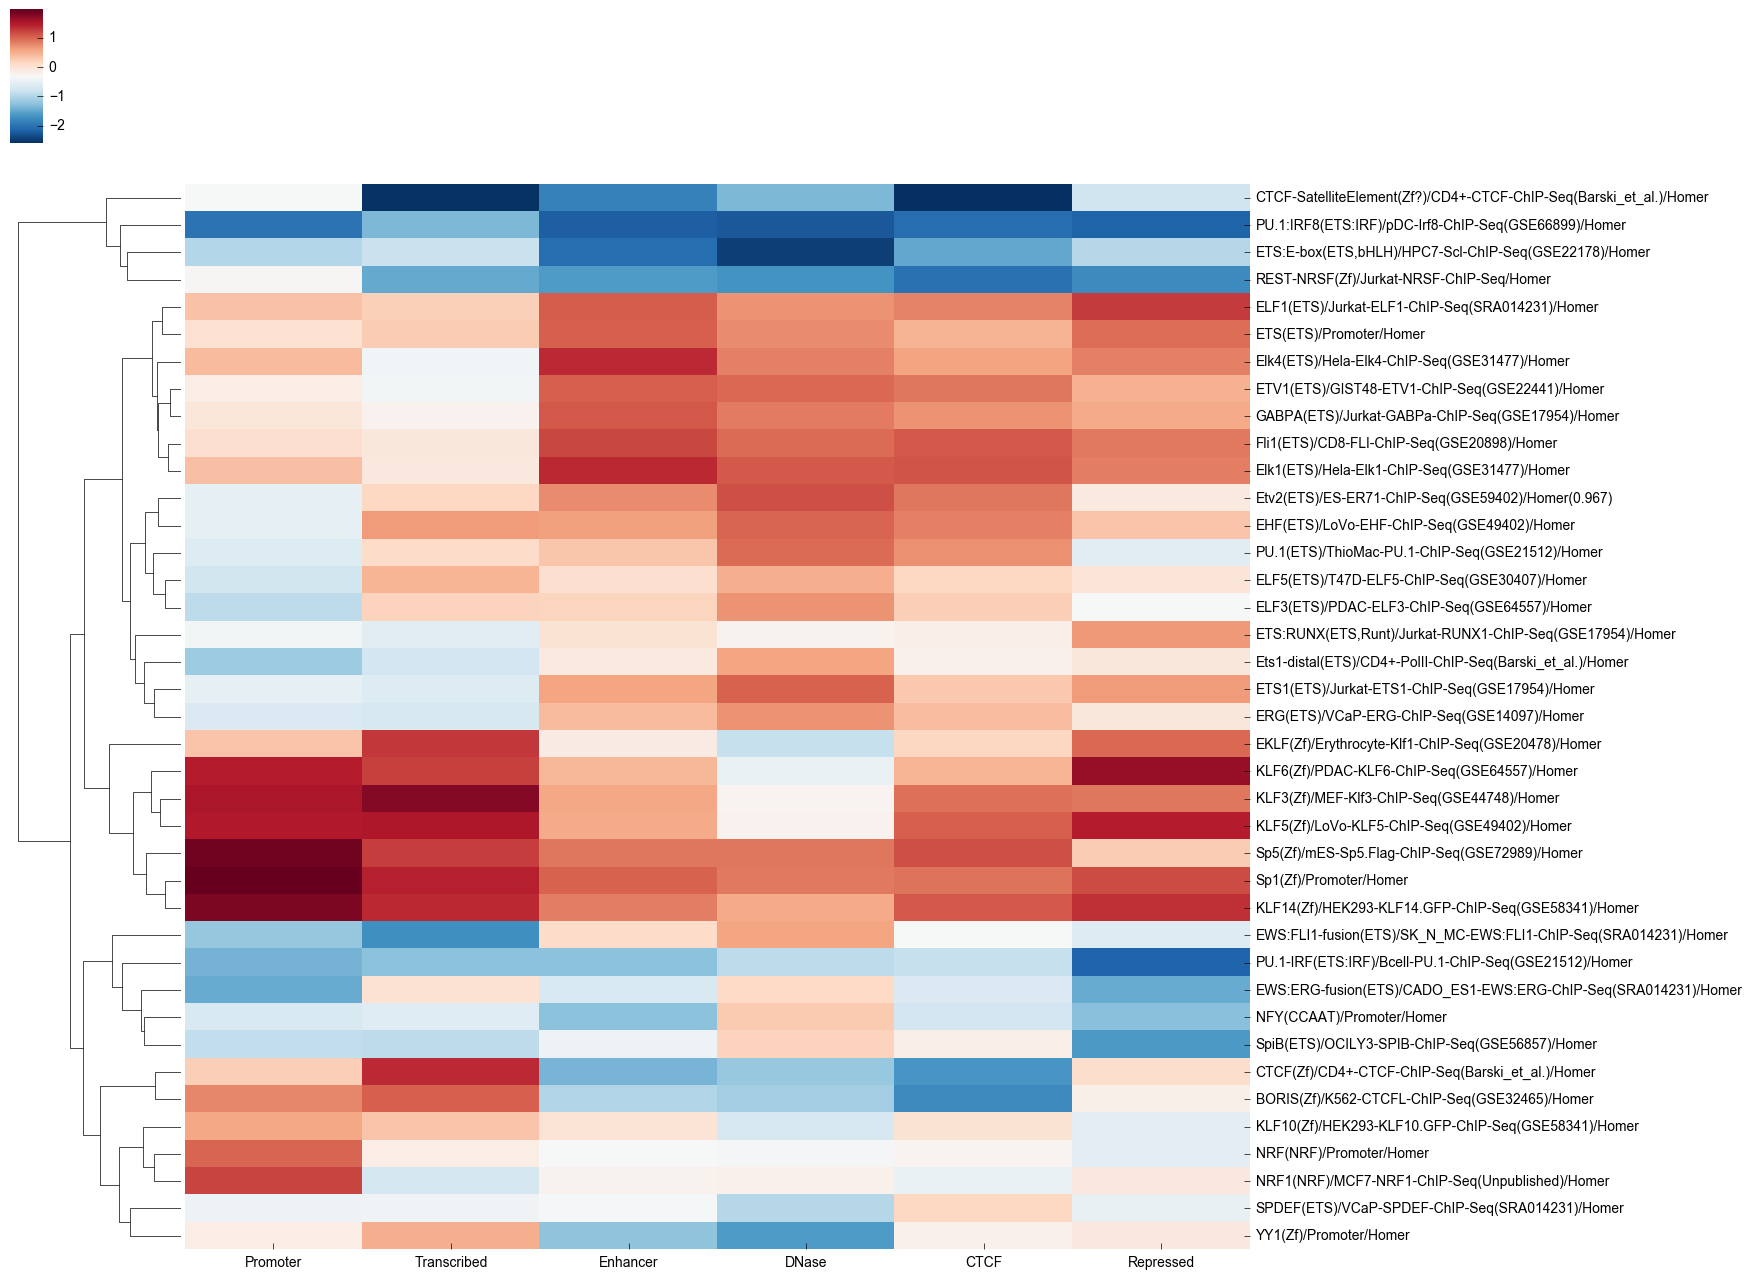

In [241]:
sns.clustermap(deeplift_corr_df,
               cmap = 'RdBu_r',
#                metric = 'correlation',
#                row_linkage = linkage,
#                col_linkage = linkage,
               z_score = 1,
               col_cluster = False,
               row_cluster = True,
#                linewidths=.75, 
               figsize=(16, 16)
              )

plt.show()

## TF-TF co-predictiveness matrix

In [41]:
corr = df.corr(method = 'spearman')

# import matplotlib.pyplot as plt
# import seaborn as sns

# # sns.clustermap(normalizedConvMatrices[0][:10000, :100])
# plt.show()

In [42]:
corr.to_csv("../plots/tfanalysis/tfcorrmatrix_24aug.tab",
              sep = '\t',
#               header = False,
#               index = False
             )

In [75]:
tfShortNames = np.array([tf.split('/')[0] for tf in corr.index])
corr.index = tfShortNames
corr.columns = tfShortNames

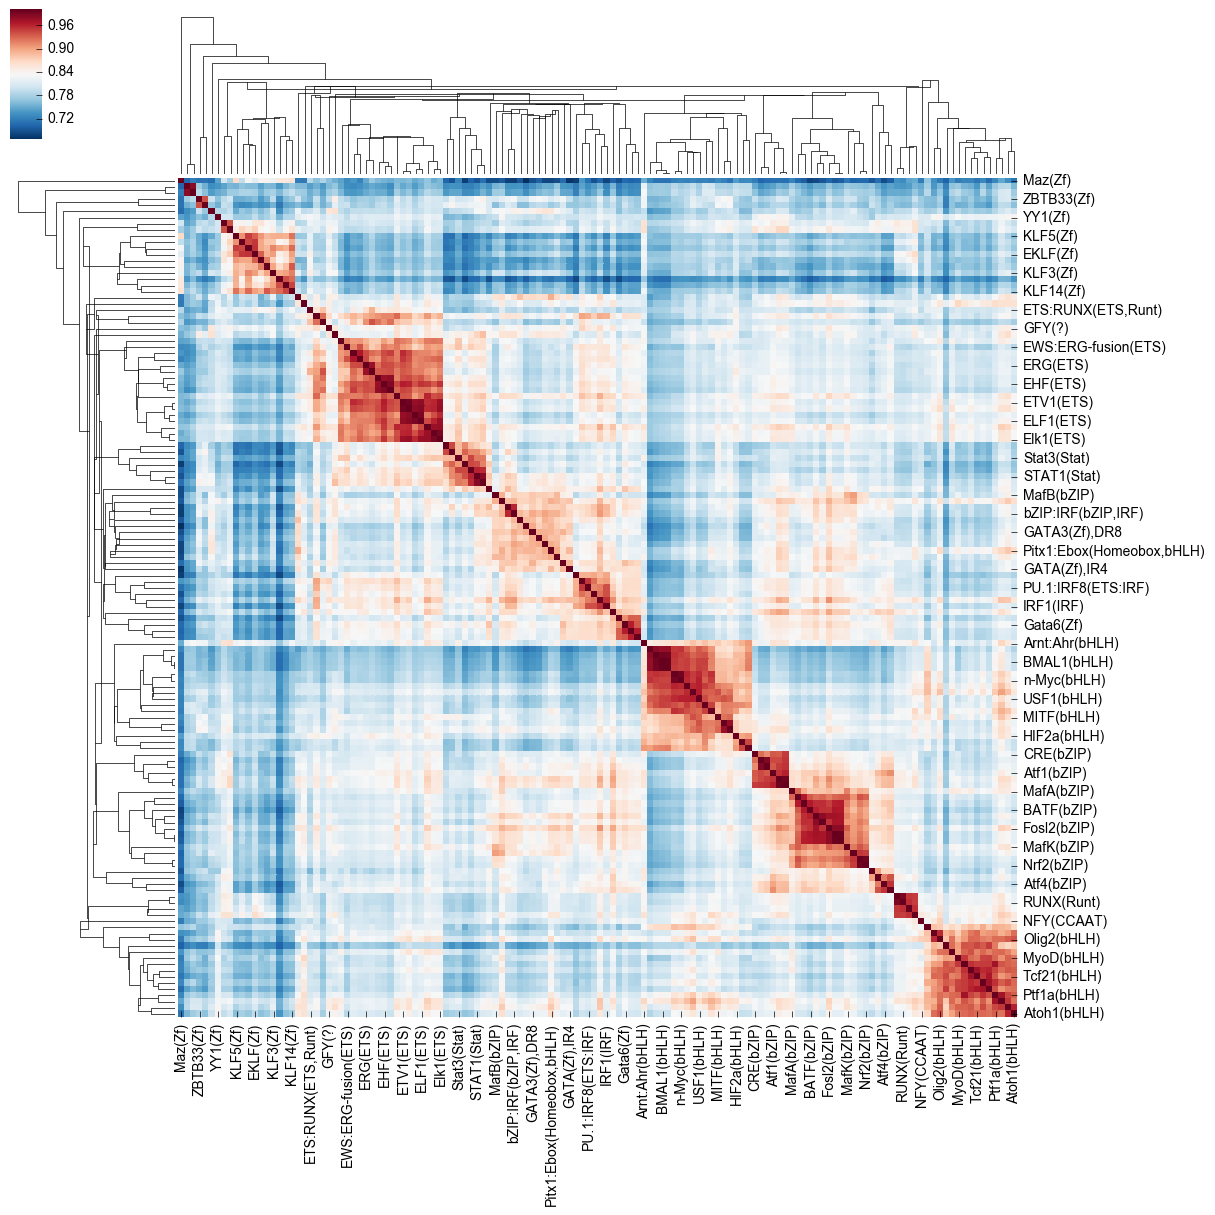

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

corrSubset = corr.iloc[corrMatMotifIdxs, corrMatMotifIdxs]

dist_matrix = 1 - corrSubset
linkage = hc.linkage(sp.distance.squareform(dist_matrix), method='median')

sns.clustermap(corrSubset,
               cmap = 'RdBu_r',
               row_linkage = linkage,
               col_linkage = linkage,
#                z_score = 0,
#                linewidths=.75, 
               figsize=(13, 13)
              )

plt.show()

# Playing around with TF PWM-sequence convolutions

Familiarizing myself with the PWM loading code, playing with scipy's convolve function to make sure we can first just find enriched HOMER motifs.

In [ ]:
import pandas as pd
import numpy as np
import glob
import time

motifpwms = {}

homer_path = '../../data/motifs/homer/*.motif'
t0 = time.time()
for homer_file in glob.glob(homer_path):
    with open(homer_file) as f:
        header = f.readline().strip().split('\t')
        name = header[1]
        threshold = float(header[2])
        weights = np.array(pd.read_csv(f, sep = '\t'))
        motifpwms[name] = weights
print("Took %.3f sec to load HOMER motifs" % (time.time() - t0))
    
# encode_motifs = '../../data/motifs/encode/motifs.txt'
# t0 = time.time()
# with open(encode_motifs) as fp:
#     line = fp.readline().strip()
#     while True:
#         if line == '':
#             break
#         header = line
#         weights = []
#         while True:
#             line = fp.readline()
#             if line == '' or line[0] == '>':
#                 break
#             weights.append(map(float, line.split()[1:]))
#         motifpwms[header] = np.array(weights)
# print("Took %.3f sec to load ENCODE motifs" % (time.time() - t0))

In [ ]:
import h5py

train_data_path = '../hdf5files/sharpr_znormed_jul23/train_data.hdf5'
data = h5py.File(train_data_path)

data_X = np.array(data['X/sequence'])
data_Y = np.array(data['Y/output'])

In [ ]:
from scipy.signal import convolve

motifs = motifpwms.keys()
pwms = np.array([motifpwms[motif].astype(np.float32) for motif in motifs])

conv_matrix = np.ndarray((len(data_X), len(motifs)))
background_conv_matrix = np.ndarray((len(data_X), len(motifs)))

idxs = np.argsort(data_Y[:, 2])[::-1][:500]
bckgrnd_idxs = np.argsort(np.abs(data_Y[:, 2]))[:500]

t0 = time.time()
t1 = time.time()
progress_update = 100
# for (i, seq) in enumerate(data_X):
for (i, idx) in enumerate(np.concatenate((idxs,bckgrnd_idxs))):
#     if i % 31 != 0:
#         continue
    if i > 3000:
        break
    if i % progress_update == 0 and i > 0:
        print("Seqs %d to %d took %.3f sec" % (i - progress_update, i, time.time() - t1))
        t1 = time.time()
    for (j, pwm) in enumerate(pwms):
        if idx in idxs:
            max_conv = np.max(convolve(data_X[idx], pwms[j], mode = 'valid').ravel())
            conv_matrix[idx][j] = max_conv
        elif idx in bckgrnd_idxs:
            max_conv = np.max(convolve(data_X[idx], pwms[j], mode = 'valid').ravel())
            background_conv_matrix[idx][j] = max_conv
        
print("All convolutions took %.3f sec" % (time.time() - t0))

In [ ]:
# print np.sum(conv_matrix, axis = 0)
# print np.sum(background_conv_matrix, axis = 0)
motifScores = np.sum(conv_matrix, axis = 0) / np.sum(background_conv_matrix, axis = 0)
sorted_idxs = np.argsort(motifScores)[::-1]
sortedMotifs = np.array(motifs)[sorted_idxs]
print motifScores[sorted_idxs[:10]]
print sortedMotifs[:10]

## Testing Av's GPU convolution function

In [8]:
import sys
import os
import numpy as np
import modisco
import modisco.util
import time

regions_to_scan = np.array([[
    [[0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.5, 0.4, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.2, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0]]
],[
    [[0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.2, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.4, 0.5, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0]]
]]).astype("float32")
filters = np.array([[
    [1.0, 0.0, 1.0, 0.0],
    [2.0, 3.0, 1.0, 0.0],
    [0.0, 0.0, 1.0, 5.0],
    [0.0, 0.0, 0.0, 0.0]
],[
    [0.0, 0.0, 0.0, 0.0],
    [5.0, 1.0, 0.0, 0.0],
    [0.0, 1.0, 3.0, 2.0],
    [0.0, 1.0, 0.0, 1.0]
]]).astype("float32")

scanning_results = np.array(modisco.util.scan_regions_with_filters(
    filters=filters,
    regions_to_scan=regions_to_scan))

print regions_to_scan.shape
print filters.shape
print scanning_results.shape

print(scanning_results)
#fwd scan: [0.5, 1.1, 1.9, 3.7, 1.0, 0.0]
#rev scan: [0.2, 0.3, 0.6, 3.3, 2.9, 0.2]
correct_answer = np.array([[[
                [0.5, 1.1, 1.9, 3.7, 2.9, 0.2],
                [0,   0,   0,   0,   1,   1]
            ],[
                [0.5, 1.1, 1.9, 3.7, 2.9, 0.2],
                [1,   1,   1,   1,   0,   0]
            ],
          ],[
                [[0.2, 2.9, 3.7, 1.9, 1.1, 0.5],
                 [0,   0,   1,   1,   1,   1]],
                [[0.2, 2.9, 3.7, 1.9, 1.1, 0.5],
                 [1,   1,   0,   0,   0,   0]]
          ]])
np.testing.assert_allclose(scanning_results, correct_answer)

Done 0
(2, 1, 4, 9)
(2, 4, 4)
(2, 2, 2, 6)
[[[[ 0.5         1.10000002  1.89999998  3.70000005  2.9000001   0.2       ]
   [ 0.          0.          0.          0.          1.          1.        ]]

  [[ 0.5         1.10000002  1.89999998  3.70000005  2.9000001   0.2       ]
   [ 1.          1.          1.          1.          0.          0.        ]]]


 [[[ 0.2         2.89999986  3.70000005  1.89999998  1.10000002  0.5       ]
   [ 0.          0.          1.          1.          1.          1.        ]]

  [[ 0.2         2.89999986  3.70000005  1.89999998  1.10000002  0.5       ]
   [ 1.          1.          0.          0.          0.          0.        ]]]]
